# Distributional Value Prediction

In [5]:
# Uncomment below lines and run this cell to install neuronav and requirements for colab.

#!git clone https://github.com/awjuliani/neuro-nav
#!pip install ./neuro-nav[experiments_remote]

In [6]:
from neuronav.envs.graph_env import GraphEnv
from neuronav.agents.dist_agents import DistQ
from neuronav.envs.graph_structures import GraphStructure
from neuronav.utils import run_episode
import matplotlib.pyplot as plt
import numpy as np

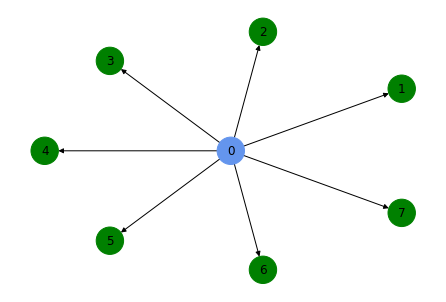

In [7]:
env = GraphEnv(graph_structure=GraphStructure.variable_magnitude)
obs = env.reset()
env.render()

Text(0, 0.5, 'Time-steps')

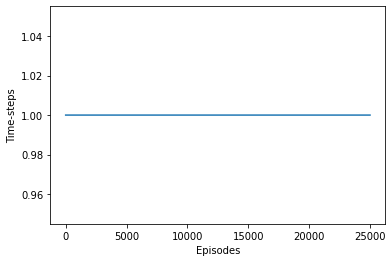

In [8]:
num_episodes = 25000
num_steps = 1

agent = DistQ(env.state_size, env.action_space.n, dist_cells=64)
total_steps = []
for i in range(num_episodes):
    agent, steps = run_episode(env, agent, max_steps=num_steps)
    total_steps.append(steps)
plt.plot(total_steps)
plt.xlabel("Episodes")
plt.ylabel("Time-steps")

<BarContainer object of 64 artists>

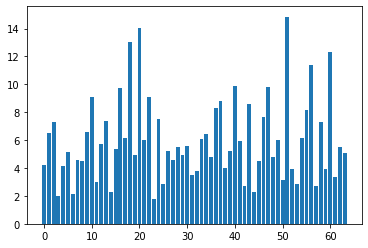

In [9]:
plt.bar(np.arange(0, agent.dist_cells), agent.Q[0, 0])